# this notebook aims to build a Variational Autoencoder with PyTorch
### (Later on maybe a TensorFlow version as well)

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

### We first want to simulate some data, say an ellipse manifold: $x^2/9 + y ^2/4 = 1$ in 2D

## <span style="color:green">Sampling 1</span>

### The sampling below is <span style="color:red">NOT</span> a uniform sample! 
### We first uniform sample from x then find the y with parametrization.
### x is uniform but (x,y) is not
### notice the scarcity of points around $x = 0$; this is expected

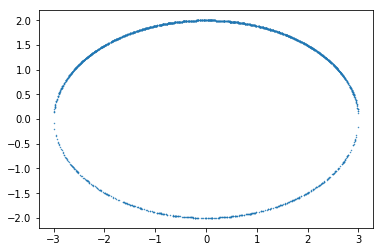

In [56]:
x_sample1 = np.random.uniform(-3,3,2000)
y_sample1 =np.sqrt(4*(1 - x_sample1**2/9))
x_sample2 = np.random.uniform(-3,3,500)
y_sample2 =-np.sqrt(4*(1 - x_sample2**2/9))
x_sample = np.concatenate((x_sample1, x_sample2))
y_sample = np.concatenate((y_sample1, y_sample2))
plt.scatter(x_sample, y_sample , s =0.2)

## <span style="color:green">Sampling 2</span>  (Uniform on the ellipse)

We first sample points from a Gaussian distribution with:<br>
mean $\mu= [0,0]^{T}$ and 
covariance $\Sigma$ = 
$\left[ \begin{array}{cccc}
4 & 0 \\
0 & 9 \\ \end{array} \right]$

Since the covariance matrix is diagonal, this can be simplied as <span style="color:red">indepently</span> sampling from 2 1-D Gaussian

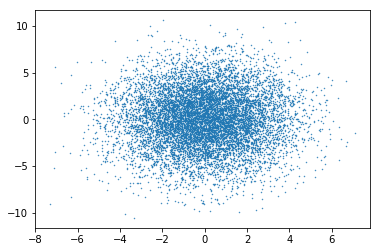

In [60]:
x_sample = np.random.normal(0, 2, 10000)
y_sample = np.random.normal(0, 3, 10000)
plt.scatter(x_sample, y_sample, s = 0.2)

## Then we scale each point to be on the ellipse $x^2/9 + y ^2/4 = 1$
## let $(x_0, y_0)$ be a sample from Gaussian, we want 
## $\lambda$ such that $\frac{(\lambda x_0)^2}{4} + \frac{(\lambda y_0)^2}{9}  = 1$
## easy to show that $\lambda = \frac{1}{\sqrt{x_0^2/9 + y_0^2/4}}$

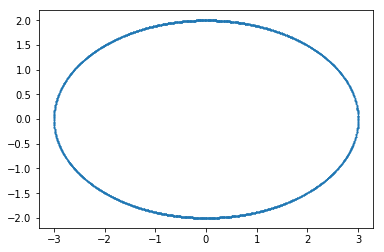

In [62]:
lambda_ = 1/np.sqrt(x_sample**2/9+y_sample**2/4)
x_sample *= lambda_
y_sample *= lambda_
plt.scatter(x_sample, y_sample, s = 0.1)

### We will use sampling method 2 to generate the simulated data moving forward

### Why Sampling 2 works?  <br>
### We want to prove that after the scaling, P(x, y) in 2 ranges with same length are the same <br>
### i.e.,  <span style="color:red">$P(x, y) \in range1 = P(x, y) \in range2$</span>,   if len(range1) = len(range2) <br>
### here range1 and range2 are segments on the ellipse $x^2/9 + y ^2/4 = 1$ 
### now range1 and range2 have their angle ranges $\Omega1, \Omega2$  a point (x,y) gets scaled to be in range1 only if (x,y) lies in the $\Omega1$ angle range (say $[\pi/9, \pi/8]$), at any 'height' c where  $x^2/9 + y ^2/4 = c$ 
### so we can write: <br>
$p(x,y) \in range1$  <br>
<br>
$= \int_{c=0}^{\infty}\int_\color{red}{\theta \in \Omega1}^{} exp(-[x,y]\Sigma^{-1}[x,y]) dc d\theta$ $~~~$ (for all $x^2/9 + y ^2/4 = c ; arctan(y/x) = \theta )$ <br> 
<br>
$= \int_{c=0}^{\infty}\int_\color{red}{\theta \in \Omega2}^{} exp(-[x,y]\Sigma^{-1}[x,y]) dc d\theta$ $~~~$($\forall$ fixed c, Gaussian distribtuion has equal prob for $\Omega1$ and $\Omega2 *$ <br>
<br>
$=p(x,y) \in range2$  

### Proved

*: in other words, if len(range1) = len(range2)  at c = 1, then on a bigger/smaller ellipse (scaled by $\lambda$) we still have len(Range1)  = len(Range2)  <br>    where Range1's angle range is $\Omega1$ and same for Range2

In [133]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

In [67]:
import torch as t

### Define VAE as the official PyTorch tutorial https://github.com/pytorch/examples/tree/master/vae ;
### Main difference is that we add a $\textbf{decode_Gaussian}$ function since our data here  are real-valued in $R^n$ (while in the original example MNIST data are in $\{0,1\}^{784}$
### Also, our input data dimension is 2 but our latent variable is of dimension 10. We make this choice as it yields a good learning capacity for the autoencoder, although usually the latent variable is of dimension much smaller than that of the data

In [1320]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(2, 20)
        #self.fc1_1 = nn.Linear(2, 2)
        self.fc21 = nn.Linear(20, 2)
        self.fc22 = nn.Linear(20, 2)
        self.fc3 = nn.Linear(2, 20)
        #self.fc3_3 = nn.Linear(2, 2)
        self.fc41 = nn.Linear(20, 2)
        self.fc42 = nn.Linear(20, 2)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.training = True

    def encode(self, x):
        #h1 = self.fc1(x)
        #h1 = self.relu(self.fc1_1(self.relu(self.fc1(x))))
        h1 = self.tanh(self.fc1(x))
        return self.fc21(h1), self.fc22(h1) # mu_z and logvar_z

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu) #element-wise
        else:
            return mu

    def decode_sigmoid(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))
    
    def decode_Gaussian(self, z):
        #h3 = self.relu(self.fc3_3(self.relu(self.fc3(z))))
        #h3 = self.fc3(z)
        h3 = self.tanh(self.fc3(z))
        return self.fc41(h3), self.fc42(h3) #mu_x and logvar_x of reconstructed x

    def forward(self, x):
        mu_z, logvar_z = self.encode(x.view(-1, 2))
        z = self.reparameterize(mu_z, logvar_z)
        return self.decode_Gaussian(z), mu_z, logvar_z
        # return mu_z and logvar_z for computing KL-div between q(z|x) and p(z)
    

### reparameterize step:
### we want to maximize the lower-bound of
$log(P_{\theta}(x))\geq E_{q_{\phi}^{}(z|x^i)} log P_{\theta}(x^i|z) -  KL (q_{\phi}(z|x)||p(z))$ $~~~$ First term on RHS is the reconstruction quality; the higher the better
### We can't take expectation directly, hence we do a Monte Carlo estimation with just  <span style="color:red">one</span> $\epsilon \sim N(0, I)$ each time, and approximate 
$E_{q_{\phi}^{}(z|x^i)} log P_{\theta}(x^i|z) \approx \frac{1}{L}\Sigma_{l=1}^{L}log P_{\theta}(x^i|z^{l}) = log P_{\theta}(x^i|z^{1})$ <br>

<br>
here we use the reparameterization trick $z^{l} = \mu + \sigma \odot \epsilon^{l}$

#### (pytorch has an easy way to take $\epsilon \sim N(0, I)$ sampling: 
$~~~$ eps = Variable(std.data.new(std.size()).normal_())

In [743]:
##pytorch way to do Normal sampling

# a = np.array([0]*10000)
# a = Variable(t.Tensor(a))
# plt.hist(a.data.new(a.size()).normal_().numpy(),bins = 20)

### In original pytorch example, it uses binary cross entropy as recon_x is in $\{0,1\}^{784}$ after the final sigmoid layer, since MNIST data is $\{0,1\}^{784}$. (i.e. it uses Bernoulli MLP as decoder. see Appendix C from VAE paper)



In [611]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function_binary(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


### For our ellipse data, let's change it to good old Gaussian decoder: <br>
$~~~logP_{\theta}(x^i|z^1) $ <br>
<br>
$ = log ~~[{|2\pi \Sigma|^{-1/2}} exp [-1/2 (x^i - \mu_x)^{T}\Sigma^{-1}(x^i - \mu_x)]]$ <br>
<br>
$ = - \frac{1}{2} log |\Sigma| -  \frac{1}{2}(x^i - \mu_x)^{T}\Sigma^{-1}(x^i - \mu_x) + {const}$ <br>
<br>
$ = -\frac{1}{2}\Sigma_j(log \sigma_j^{2}) - \frac{1}{2}\Sigma_{j}[(x^i_j - \mu_{x,j})^2\sigma_{x,j}^{-2}] + const$ <br>

### here $\Sigma$ is diagonal matrix with $[\sigma_{x,1},\sigma_{x,2}, ...]$ on diagonal

In [1034]:
def loss_function_Gaussian(mu_x, logvar_x, x_i, mu_z, logvar_z):
    var_x = logvar_x.exp()
    
    Gaussian_ll = -0.5* t.sum(logvar_x) - 0.5* t.sum(((x_i - mu_x)**2).mul(1/var_x))
    
    KLD = -0.5 * t.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())
    return -(Gaussian_ll - 0.5 * KLD)  # this is -1(Gaussian_ll - KLD), and we want to maximize the (Gaussian_ll -  KLD) part

In [627]:
# logvar_z = t.Tensor([1,2])
# 1/logvar_z
# t.sum(logvar_z)

In [507]:
# x = t.Tensor([1,2])
# mu = t.Tensor([4,3])
# var_z = t.Tensor([4,9])
# t.sum(((x - mu)**2).mul(var_z))

### wrap the previous Sampling method 2 into a function

In [1321]:
def ellipse_2D(N, mu_x1, mu_x2, a, b):
    x1_sample = np.random.normal(0, a, N)
    x2_sample = np.random.normal(0, b, N)
    lambda_ = 1/np.sqrt(x1_sample**2/(a**2)+x2_sample**2/(b**2))
    x1_sample *= lambda_
    x2_sample *= lambda_
    x1_sample +=mu_x1
    x2_sample +=mu_x2
    return np.concatenate(([x1_sample], [x2_sample])).transpose()


In [1322]:
n = 10000
bsize = 1000
mu_x1= 0
mu_x2 = 0
a = 3
b = 2
log_interval = 50
epochs = 500

In [1323]:
x = t.Tensor(ellipse_2D(N = n, mu_x1 =mu_x1, mu_x2=mu_x2, a=a, b=b))
y = t.Tensor(np.ones(n).reshape(n,1))

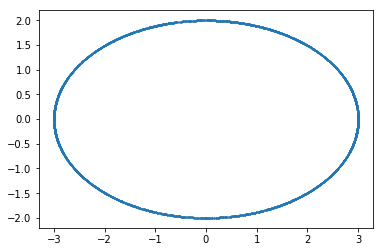

In [1324]:
plt.scatter(Variable(x).data.numpy().transpose()[0],Variable(x).data.numpy().transpose()[1],s=0.2)

In [1325]:
ellipse_train = torch.utils.data.TensorDataset(x, y)
ellipse_loader = torch.utils.data.DataLoader(ellipse_train, batch_size = bsize) # create your dataloader

In [1326]:
def train(epoch, loader):
    loader = ellipse_loader
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(loader):
        #just need the data, don't need the dummy label for VAE :)
        data = Variable(data)
        optimizer.zero_grad()
        (mu_x, logvar_x), mu_z, logvar_z = model(data)
        loss = loss_function_Gaussian(mu_x, logvar_x, data, mu_z, logvar_z) #minimize the - loss = maximize lower bound
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader),
                loss.data[0] / len(data)))
            

#     print('====> Epoch: {} Average loss: {:.4f}'.format(
#           epoch, train_loss / len(loader.dataset)))
    return (-train_loss/len(loader.dataset))  #record average loss at current iteration

In [1327]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


### Training

In [1354]:
np.random.seed(seed = 12345)
torch.manual_seed(12345)
epochs = 1000
loss_iter = np.zeros(epochs)
for epoch in range(1, epochs + 1):
    loss_ = train(epoch, ellipse_loader)
    loss_iter[epoch - 1] = loss_
    
    

### The negative loss function over iterations

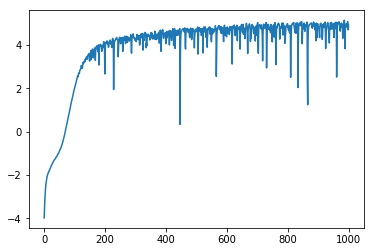

In [1329]:
plt.plot(range(epochs),loss_iter)

### We want to generate new data with the trained autoencoder; we compare two methods below.

### generate new data via $p(x) = \int p(z)~p_{\theta}(x|z)~dz$

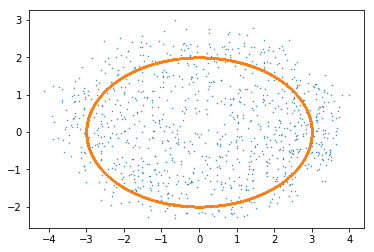

In [1331]:
sample = Variable(t.randn(1000, 2))
sample = model.decode_Gaussian(sample)
std = sample[1].exp_().sqrt()
sample_x1 = np.random.normal(0,1,1000) * std.data.numpy()[:,0] + sample[0].data.numpy().transpose()[0]
sample_x2 = np.random.normal(0,1,1000) * std.data.numpy()[:,1] + sample[0].data.numpy().transpose()[1]
plt.scatter(sample_x1,sample_x2,s=0.2)
plt.scatter(Variable(x).data.numpy().transpose()[0],Variable(x).data.numpy().transpose()[1],s=0.2)

### generate new data via $p(x^{new}|x) = \int p(x^{new}|z)~p_{\theta}(z|x)~dz$

In [1391]:
x[9000]


-2.5147
 1.0906
[torch.FloatTensor of size 2]

In [1382]:
data


-2.5147  1.0906
 2.6450  0.9438
 0.6747  1.9488
       ⋮        
 2.1399  1.4017
 2.0333 -1.4706
 2.9959 -0.1043
[torch.FloatTensor of size 1000x2]

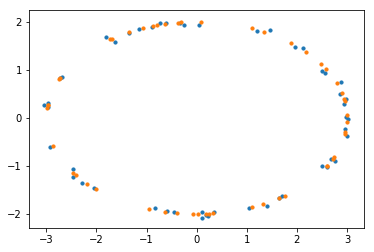

In [1409]:
for batch_idx, (data_, _) in enumerate(ellipse_loader):
    if batch_idx ==0:
        true_data = Variable(data_)
        (mu_x, logvar_x), mu_z, logvar_z = model(true_data) #forward prop
std = logvar_x.exp_().sqrt()
draw_n = 50
draw_size = 10 
sample_x1 = np.random.normal(0,1,bsize) * std.data.numpy()[:,0]*30 + mu_x.data.numpy().transpose()[0]
sample_x2 = np.random.normal(0,1,bsize) * std.data.numpy()[:,1]*30 + mu_x.data.numpy().transpose()[1]
plt.scatter(sample_x1[:draw_n],sample_x2[:draw_n],s=draw_size)
plt.scatter(true_data.data.numpy().transpose()[0][:draw_n],true_data.data.numpy().transpose()[1][:draw_n],s=draw_size)
    

### The second method yields better reconstructed data, but it seems to be an identity mapping! In other words, we haven't really found a truly representative latent code space of the input data. This could be because our input data dimension is <span style="color:red">too low (d = 2) to start with </span>

### Next we build a VAE to learn data coming from a Gaussian Mixture Model (GMM) in 2D. 

In [1159]:
def GMM_2D(N, mu_x1, mu_x2, a, b):
    x1_sample = np.random.normal(0, a, N)
    x2_sample = np.random.normal(0, b, N)
    lambda_ = 1/np.sqrt(x1_sample**2/(a**2)+x2_sample**2/(b**2))
    x1_sample +=mu_x1
    x2_sample +=mu_x2
    return np.concatenate(([x1_sample], [x2_sample])).transpose()



In [1160]:
n = 5000

x_c1 = t.Tensor(GMM_2D(N = n, mu_x1 = -6 , mu_x2= -6, a=3, b=2))
x_c2= t.Tensor(GMM_2D(N = n, mu_x1 = 6, mu_x2=  6, a=2, b=3))
y_c1 = t.Tensor(np.ones(n).reshape(n,1))
y_c2 = t.Tensor(np.ones(n).reshape(n,1))
x = t.cat((x_c1,x_c2))
y = t.cat((y_c1,y_c2))

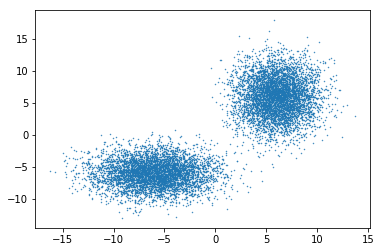

In [1211]:
## the data
plt.scatter(Variable(x).data.numpy().transpose()[0],Variable(x).data.numpy().transpose()[1],s=0.2)

In [1253]:
np.random.seed(seed = 12345)
torch.manual_seed(12345)

In [1254]:
GMM_train = torch.utils.data.TensorDataset(x, y)
GMM_loader = torch.utils.data.DataLoader(GMM_train, batch_size = bsize, shuffle = True) # create your dataloader

In [1255]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [1353]:
epochs = 1500
loss_iter = [0]*epochs
for epoch in range(1, epochs + 1):
    loss_ = train(epoch = epoch,loader = GMM_loader)
    loss_iter[epoch - 1] = loss_

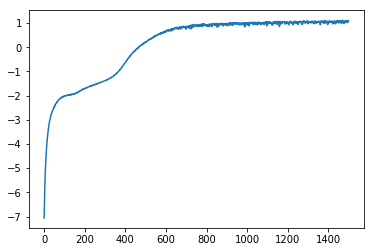

In [1257]:
plt.plot(range(epochs),loss_iter)

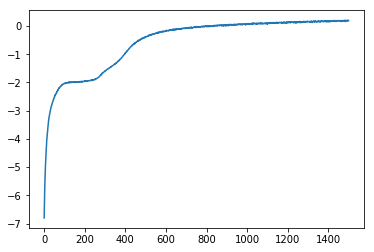

In [1242]:
plt.plot(range(epochs),loss_iter)

### generate new data via $p(x) = \int p(z)~p_{\theta}(x|z)~dz$

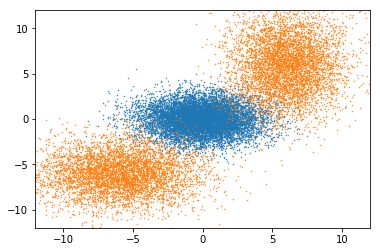

In [1258]:
sample = Variable(t.randn(10000, 20))
sample = model.decode_Gaussian(sample)
std = sample[1].exp_().sqrt()
sample_x1 = np.random.normal(0,1,10000) * std.data.numpy()[:,0] + sample[0].data.numpy().transpose()[0]
sample_x2 = np.random.normal(0,1,10000) * std.data.numpy()[:,1] + sample[0].data.numpy().transpose()[1]
plt.ylim((-12,12))
plt.xlim((-12,12))
plt.scatter(sample_x1,sample_x2,s=0.2)
plt.scatter(Variable(x).data.numpy().transpose()[0],Variable(x).data.numpy().transpose()[1],s=0.2)

### generate new data via $p(x^{new}|x) = \int p(x^{new}|z)~p_{\theta}(z|x)~dz$

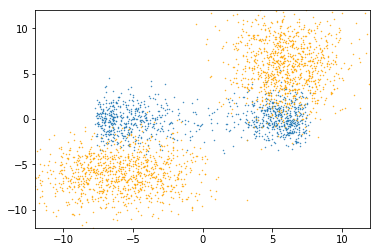

In [1259]:
for batch_idx, (data, _) in enumerate(GMM_loader):
    if batch_idx ==0:
        data = Variable(data)
        (mu_x, logvar_x), mu_z, logvar_z = model(data)
std = logvar_x.exp_().sqrt()
sample_x1 = np.random.normal(0,1,bsize) * std.data.numpy()[:,0] + mu_x.data.numpy().transpose()[0]
sample_x2 = np.random.normal(0,1,bsize) * std.data.numpy()[:,1] + mu_x.data.numpy().transpose()[1]
plt.ylim((-12,12))
plt.xlim((-12,12))
plt.scatter(sample_x1,sample_x2,s=0.2)

plt.scatter(Variable(x).data.numpy().transpose()[0][0:1000],Variable(x).data.numpy().transpose()[1][0:1000],s=0.2,c='orange')
plt.scatter(Variable(x).data.numpy().transpose()[0][-1000:],Variable(x).data.numpy().transpose()[1][-1000:],s=0.2,c='orange')

### Again the second method generates data that better reconstructs the original data. 

In [ ]:
## 